# Python code for toxic comments Detection

### Examining the Python Version that was utilized in this study

In [1]:
import sys
sys.version

'3.7.11 (default, Jul  3 2021, 18:01:19) \n[GCC 7.5.0]'

### Importing Libraries
The bulk of a programming language is in its libraries. To use the application a library module must be imported. Use help to understand what is in the library module. Import certain parts from a library to shorten programs. (https://docs.python.org/3/library/index.html)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

###  Reading the Dataset

In [3]:
#Read the csv file into dataframe df
Toxic_df = pd.read_csv("/content/ToxicDataSet.csv", encoding = 'utf8')
print(Toxic_df.shape)

(159571, 8)


### Profiling of Data
Profiling data is the process of analyzing and gathering statistics or useful summaries of accessible data from current information sources(Hildebrandt, 2015).

In [4]:
!pip install pandas-profiling==2.7.1

In [5]:

import pandas_profiling


In [6]:
pandas_profiling.ProfileReport(Toxic_df)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

###  Randomly selecting records from dataset for further processing
It is important to select the sample members randomly, because it prevents bias in your results. (Morgan Kauffman, 2005)

In [7]:
import random
Toxic_ds_sub = Toxic_df.sample(random.randint(11000,15000), random_state=1)

In [8]:
print(Toxic_ds_sub.shape)

(11982, 8)


In [9]:
Toxic_ds_sub.head()

,id,comment_text,toxic,severe_toxic,obscene_flag,threat_flag,insult_flag,identity_hate_flag
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0
53891,8ff87747403ed2e6,Why are my posts being deleted? \n\nI have tri...,0,0,0,0,0,0
154159,a95604c7a938abb3,"""\n\n Controlled Demolitions and Common Sense ...",0,0,0,0,0,0
13040,2288910537399720,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0


### List of various fields used in the dataset

In [10]:
print(Toxic_ds_sub.dtypes)

id                    object
comment_text          object
toxic                  int64
severe_toxic           int64
obscene_flag           int64
threat_flag            int64
insult_flag            int64
identity_hate_flag     int64
dtype: object


This research has utilized enough large data set and '159566' lines of remark. It needs high-performance systems.

Furthermore, the test split on a vast pre-processed data frame was often carried out, leading to the machine's storage failure.

In order to deal with this problem, the reindexing process was performed using 'dataset sub. Reindex' to mix all the indicators first. It helps to produce good outcomes while dividing the dataset afterward.

In [11]:
#The below method indices to scramble to prevent using train data and test data split later.
dataset_sub = Toxic_ds_sub.reindex(np.random.permutation(Toxic_ds_sub.index))

In [12]:
#Separating the comment field from dataset
comment = Toxic_ds_sub['comment_text']
print(comment.head())

24915     YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...
75819     Agent X2: Basically thanks - with a 'little' m...
53891     Why are my posts being deleted? \n\nI have tri...
154159    "\n\n Controlled Demolitions and Common Sense ...
13040     I do not understand your reply.  //Blaxthos ( ...
Name: comment_text, dtype: object


In [13]:
comment = comment.to_numpy()

### Separating all labels from dataset

In [14]:
label = Toxic_ds_sub[['toxic', 'severe_toxic' , 'obscene_flag' , 'threat_flag' , 'insult_flag' , 'identity_hate_flag']]
print(label.head())
label = label.to_numpy()

        toxic  severe_toxic  ...  insult_flag  identity_hate_flag
24915       1             1  ...            1                   0
75819       0             0  ...            0                   0
53891       0             0  ...            0                   0
154159      0             0  ...            0                   0
13040       0             0  ...            0                   0

[5 rows x 6 columns]


In [15]:
label.shape

(11982, 6)

### Counting the frequency of appearance of the labels
 label_Freq1 :-   Number of comments with atleast one label

label_Freq2 :- Number of comments with more than one label 

In [16]:
label_freq1,label_freq2 = 0,0
for i in range(label.shape[0]):
    freq = np.count_nonzero(label[i])
    if freq :
        label_freq1 = label_freq1+1
    if freq>1 :
        label_freq2 = label_freq2+1
print(label_freq1)
print(label_freq2)

1253
752


### Data Visualisations
 Analysis of comment no. with lengths varying between 0 and 1200 

average length of comment: 395.905


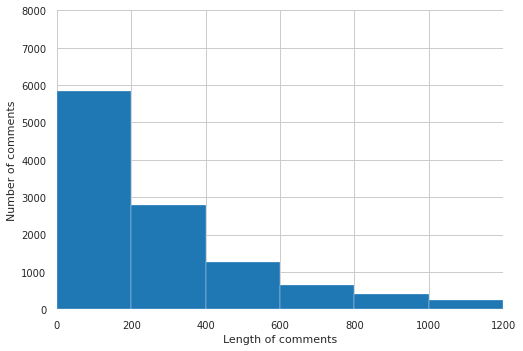

In [17]:

x = [len(comment[i]) for i in range(comment.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 8000])
plt.grid(True)
plt.show()

### Analysis of comments labeled as insult, toxic, sever_toxic etc. on the basis of length of comment

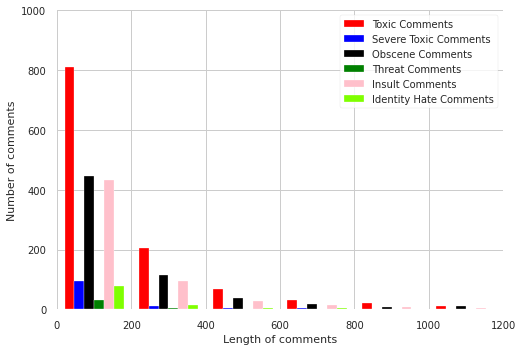

In [18]:
y = np.zeros(label.shape)
for ix in range(comment.shape[0]):
    l = len(comment[ix])
    if label[ix][0] :
        y[ix][0] = l
    if label[ix][1] :
        y[ix][1] = l
    if label[ix][2] :
        y[ix][2] = l
    if label[ix][3] :
        y[ix][3] = l
    if label[ix][4] :
        y[ix][4] = l
    if label[ix][5] :
        y[ix][5] = l

labelsplt = ['Toxic Comments','Severe Toxic Comments','Obscene Comments','Threat Comments','Insult Comments','Identity Hate Comments']
color = ['red','blue','black','green','pink','chartreuse']        
plt.hist(y,bins = bins,label = labelsplt,color = color)
plt.axis([0, 1200, 0, 1000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

### Elimination of Lengthy comments

Some pervasive remarks may be observed in the dataset. There is a risk that too many words will be added to the training dataset.

This can help to increase training duration and reduce model accuracy.

This results in a 400 character barrier, and only comments with fewer than 400 characters are used.

In [19]:
comments = []
labels = []

for ix in range(comment.shape[0]):
    if len(comment[ix])<=400:
        comments.append(comment[ix])
        labels.append(label[ix])

In [20]:
labels = np.asarray(labels)

In [21]:
print(len(comments))

8660


# Preprocessing

###  Prepare a list of all the punctuations to delete.

The library of strings includes the character punctuation. All numbers will be added to this list and imported. The dataset clearly shows a field of the comment text comprising words like 'not, did,' etc, including apostrophes ('). In the escape sequence notation, the 'represented character' is substituted by the blank character in the punctuation chain to prevent turning such words into wont.

In [22]:
import string
print(string.punctuation)
punctuation_edit = string.punctuation.replace('\'','') +"0123456789"
print (punctuation_edit)
outtab = "                                         "
trantab = str.maketrans(punctuation_edit, outtab)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789


### Update the stop words list

In both written and oral correspondence, stop words are widely employed, and so have neither detrimental nor positive influence on our argument.
If there is no practical significance in existing or generated in one letter due to any pre-processing phase, it can be deleted.
Thus, letters from b to z should be included in lists of specially imported stop words.


In [23]:
import nltk
from nltk.corpus import stopwords
#nltk.download()
nltk.download('stopwords')
stop_words = stopwords.words('english')
#print [i for i in sentence.split() if i not in stop]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
print (stop_words)

{'your', 'he', 'up', 'you', 'isn', "hasn't", 'same', 'are', "that'll", "hadn't", 'a', 'own', 'whom', 'there', 'itself', 'too', 've', 'then', "don't", 'these', "it's", 'most', 'against', 'where', 'was', 'so', 'd', 'not', "should've", "wouldn't", 'how', "didn't", 'm', 'they', 's', 'doing', 'this', 'who', 'were', 'be', 'been', 'do', 'to', 'mightn', 'for', 'ain', 'and', 'our', 'the', 'did', 'had', 'y', 'him', 'is', "isn't", "aren't", 'it', 'yours', "needn't", 'when', 'doesn', 'o', 'both', 'them', 'should', 'down', 't', "she's", 'what', 'nor', 'her', 'themselves', 'yourselves', 'aren', 'theirs', 'won', 'about', 'here', 'those', 'yourself', "mustn't", 'me', 'an', "shouldn't", 'while', 'out', 'himself', 'myself', "mightn't", 'very', "doesn't", 'from', 'any', 'below', 'between', "you'd", "shan't", 'their', 'during', 'if', 'we', 'through', 'can', 're', 'now', 'which', "weren't", "won't", 'wasn', 'his', 'she', 'will', 'ours', 'has', 'all', 'needn', 'only', 'few', 'ma', 'no', 'mustn', 'have', 'by

Stemming is the process by which inflected / derived words are turned into a root or stem. Some associated terms of origin in the same word have been changed. This helps to make the training process more accurate.
Lemmatization means combining the inflected forms of a word into one object in order to examine them. It is almost derived from its study but differently since a sentence relies on the proper definition to the required feature of the vocabulary and meaning of a term (Huilgol 2020).. A larger context that surrounds the word, including neighboring words or a full book. The wordnet library is therefore utilized in nltk.
Also imported are Stemmer and Lemmatizer.

In [26]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [27]:
#create objects for stemmer and lemmatizer
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()
#download words from wordnet library
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### looping through all the comments

 - Removal of Punctuation
 - Operation of stem and lemmatizer
 -Divide words into space
 - Recombining terms for future care

In [28]:
for i in range(len(comments)):
    comments[i] = comments[i].lower().translate(trantab)
    l = []
    for word in comments[i].split():
        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    comments[i] = " ".join(l)

### Apply the Count Vectorizer

Statements may eventually be converted into a matrix of token counts, which indicates the number of occurrences.

In [29]:
#Import the library required
from sklearn.feature_extraction.text import CountVectorizer

#Create an object that supplies our custom stop words
count_vector = CountVectorizer(stop_words=stop_words)
#Fitting it to converts comments into bag of words format
tf = count_vector.fit_transform(comments).toarray()

In [30]:
# print(count_vector.get_feature_names())
print(tf.shape)

(8660, 14746)


### Splitting dataset into training and testing
 
To solve the problem in the beginning, all the indices were jumbled, the system was running out of memory by train test split.

In [31]:
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion)
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:,:]
    Y_test =  target[:ratio,:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = shuffle(tf, labels,3)

print(X_test.shape)
print(X_train.shape)

(2886, 14746)
(5774, 14746)


### Implementation of classifiers 

In [32]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def evaluate_score(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

##1.Multinomial Naïve Bayes classifier using Label Powerset method

In [33]:
#create and fit classifier
!pip install scikit-multilearn
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import LabelPowerset
classifier = LabelPowerset(MultinomialNB())
classifier.fit(X_train, Y_train)

LabelPowerset(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                       fit_prior=True),
              require_dense=[True, True])

In [34]:
#predictions
predictions = classifier.predict(X_test)

In [35]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 4.227304227304227
Accuracy : 85.86278586278586
Log_loss : 1.6093610348269716


##2.Binary Relevance Method with SVM classifier

In [36]:
!pip install scikit-multilearn
from skmultilearn.problem_transform import BinaryRelevance

In [37]:
#create and fit classifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
classifier2 = BinaryRelevance(classifier = SVC(), require_dense = [False, True])
classifier2.fit(X_train, Y_train)

BinaryRelevance(classifier=SVC(C=1.0, break_ties=False, cache_size=200,
                               class_weight=None, coef0=0.0,
                               decision_function_shape='ovr', degree=3,
                               gamma='scale', kernel='rbf', max_iter=-1,
                               probability=False, random_state=None,
                               shrinking=True, tol=0.001, verbose=False),
                require_dense=[False, True])

In [38]:
#predictions
predictions2 = classifier2.predict(X_test)

In [39]:
#calculate scores
evaluate_score(Y_test,predictions2)

Hamming_loss : 3.7075537075537075
Accuracy : 87.5952875952876
Log_loss : 1.5409714818684799


### 3. Binary Relevance (BR) Method with Multinomial Naïve Bayes 

In [40]:
# Clf shall be a list of all 6 labels
# The training data and the accompanying classifier are appropriate for each classifier
clf = []
for ix in range(6):
    clf.append(MultinomialNB())
    clf[ix].fit(X_train,Y_train[:,ix])

In [41]:
# Predict list contains the predictions, which are translated to the correct form later
predict = []
for ix in range(6):
    predict.append(clf[ix].predict(X_test))

predict = np.asarray(np.transpose(predict))
print(predict.shape)

(2886, 6)


In [42]:
# Compute results
evaluate_score(Y_test,predict)

Hamming_loss : 4.654654654654655
Accuracy : 85.16978516978517
Log_loss : 2.348796412427081


### 4. Multinomial Naïve Bayes classifier using Classifier chain method

In [43]:
#create and fit classifier
from skmultilearn.problem_transform import ClassifierChain
classifier = ClassifierChain(MultinomialNB())
classifier.fit(X_train, Y_train)

ClassifierChain(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                         fit_prior=True),
                order=None, require_dense=[True, True])

In [44]:
#predictions
predictions = classifier.predict(X_test)

In [45]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 4.787479787479787
Accuracy : 85.23908523908524
Log_loss : 2.0033681545392104


##5.  Binary Relevance (BR) Method with Multinomial Naïve Bayes classifier

In [46]:
#create and fit classifier
classifier3 = BinaryRelevance(classifier = MultinomialNB(), require_dense = [False, True])
classifier3.fit(X_train, Y_train)

BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                         fit_prior=True),
                require_dense=[False, True])

In [47]:
#predictions
predictions3 = classifier3.predict(X_test)

In [48]:
#calculate scores
evaluate_score(Y_test,predictions3)

Hamming_loss : 4.654654654654655
Accuracy : 85.16978516978517
Log_loss : 2.348796412427081


### 6. Gaussian Naïve Bayes classifier using Binary relevance method

In [49]:
from sklearn.naive_bayes import GaussianNB
#create and fit classifiers
clf = []
for ix in range(6):
    clf.append(GaussianNB())
    clf[ix].fit(X_train,Y_train[:,ix])

In [50]:
#predictions
predict = []
for ix in range(6):
    predict.append(clf[ix].predict(X_test))

In [51]:
#calculate scores
predict = np.asarray(np.transpose(predict))
evaluate_score(Y_test,predict)

Hamming_loss : 10.550935550935552
Accuracy : 70.44352044352044
Log_loss : 2.311471830918073


### 7. Back Propagation for Multi-label Neural Networks 

In [52]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [53]:
#define model architecture
model = Sequential()
model.add(Dense(4, activation='relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 58988     
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 30        
Total params: 59,018
Trainable params: 59,018
Non-trainable params: 0
_________________________________________________________________


In [54]:
#compile model with all parameters set
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
#Fit using check pointer
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.myneural.h5py', 
                               verbose=1, save_best_only=True)
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
181/181 [==============================] - 2s 6ms/step - loss: 0.4597 - accuracy: 0.2962
Epoch 2/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4506 - accuracy: 0.3008
Epoch 3/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4429 - accuracy: 0.2903
Epoch 4/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4343 - accuracy: 0.3124
Epoch 5/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4391 - accuracy: 0.3150
Epoch 6/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4425 - accuracy: 0.3185
Epoch 7/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4559 - accuracy: 0.3185
Epoch 8/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4501 - accuracy: 0.2544
Epoch 9/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4691 - accuracy: 0.1943
Epoch 10/10
181/181 [==============================] - 1s 6ms/step - loss: 0.4994 - accuracy: 0.2148

In [56]:
#predictions
predict = model.predict(X_test)

In [57]:
print(predict[0])

[0.38694313 0.09422804 0.27994362 0.02253551 0.1669539  0.04939581]


#### The results of the model are in the form of probabilities and Hamming loss and log loss deon't work on decimal values. Hence, it is very essential to convert the probabilites in the form 0 and 1.

#### Moreover, log losses can directly calculate without changing the values.

In [58]:
#calculate score
loss = log_loss(Y_test,predict)
print("Log_loss : {}".format(loss))
predict = np.round(predict)
loss = hamming_loss(Y_test,predict)
print("Hamming_loss : {}".format(loss*100))
accuracy = accuracy_score(Y_test,predict)
print("Accuracy : {}".format(accuracy*100))


Log_loss : 0.49910273518243403
Hamming_loss : 4.417879417879418
Accuracy : 86.13998613998614


### Visualisation of Output Results

In [59]:
# Importing Necessary Libraries for Visualization
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import itertools

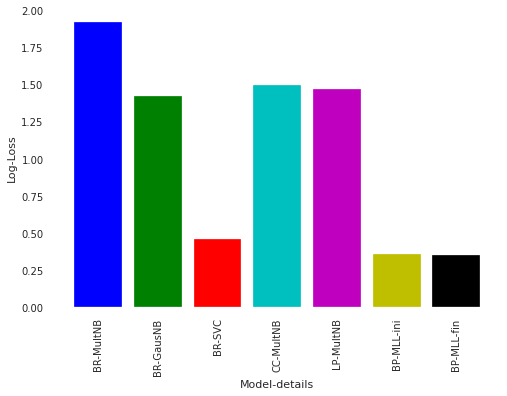

In [60]:
x = ['BR-MultNB','BR-GausNB','BR-SVC','CC-MultNB','LP-MultNB','BP-MLL-ini','BP-MLL-fin']
y = [1.92,1.422,0.46,1.5,1.47,0.36,0.35]
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.ylabel('Log-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i], color=next(colors))
plt.show()

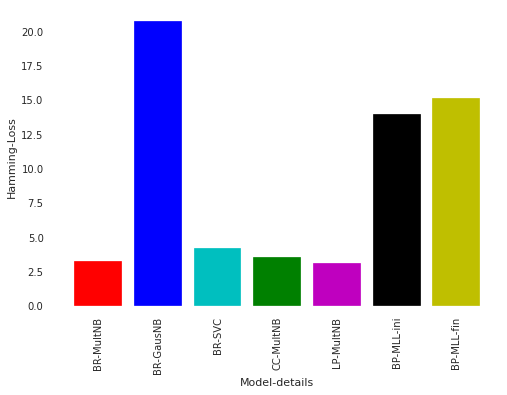

In [61]:
x = ['BR-MultNB','BR-GausNB','BR-SVC','CC-MultNB','LP-MultNB','BP-MLL-ini','BP-MLL-fin']
y = [3.27,20.74,4.26,3.56,3.17,13.96,15.158]
colors = itertools.cycle(['r', 'b', 'c', 'g', 'm', 'k', 'y'])
plt.ylabel('Hamming-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i], color=next(colors))
plt.show()

The SVM performity binary classification technique has a 4.72 percent hammer loss which is somewhat higher than the Naif Bayes model with a log loss of 0.50.
Multi-label networks with back propagation parameters (batch size 32 and epochs 10). The outcome here was a hamming loss of 11.87% and a loss of 0.39%.
This is designed to improve log loss performance over the Naïve Bayes model for neural networks.

##Reference
Hildebrandt, M. FIDIS Deliverable D7.2 — Descripitve analysis and inventory of profiling practices. Brussels 2015.

I. H. Witten Data Mining:Practical Machine Learning Tools and Techniques: Morgan Kauffman, 2005.

Maron, M.E.: Automatic indexing: An experimental inquiry. J. ACM 8, 404–417 (1961)

Rennie, J.D.: Tackling the poor assumptions of naive bayes text classifiers. In: ICML 2003, pp. 616–623 (2003)